# Imports

In [13]:
import pandas as pd
import numpy as np
import processing
import sklearn.decomposition as sk_decomp
import sklearn.ensemble as sk_ens
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
%matplotlib inline

# Read Data

In [14]:
DATA_DIR = "data/raw/us_census.csv"

In [15]:
df = pd.read_csv(DATA_DIR)

# Summary Stats

In [16]:
df.describe()

,age,detailed_industry_recode,detailed_occupation_recode,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,instance_weight,num_persons_worked_for_employer,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


In [17]:
df.head(2)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,label
0,0,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
1,0,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.


In [18]:
processing.missing_values_report(df)

In total we have 199523 rows and 42 columns.

 There are 0 columns that have missing values. 
 Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


# Exploration

## Cleaning

In [19]:
# encode columns
encoded_df = processing.encode_labels(df)

# split
X, y = processing.split_features_and_labels(encoded_df)

# process
X = processing.one_hot_encode(X)
X = processing.scale_features(X)


 Replacing the column label according to mapping {' - 50000.': 0, ' 50000+.': 1}

 Splitting the dataframe into features and labels
Features:  ['age', 'class_of_worker', 'detailed_industry_recode', 'detailed_occupation_recode', 'education', 'wage_per_hour', 'enroll_in_edu_inst_last_wk', 'marital_stat', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_stat', 'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'instance_weight', 'migration_code_change_in_msa', 'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother', '

## Target Variable Distribution

In [23]:
df['label'].value_counts(normalize=True)

 - 50000.    0.937942
 50000+.     0.062058
Name: label, dtype: float64

We can see the target variable is extremely imbalanced with most people earning less than $50,000. We would need to make sure this is a fair representation of the actual population. 

When training our model we use oversampling techniques to feed more observation of "-50000" and avoid the model only predicting the "-50000" label. We could also design a cost function who's objective is to get a similar accuracy on all classes. 

## Scatterplot

In [15]:
pd.plotting.scatter_matrix(df, figsize=(50,50))

array([[<AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='detailed_industry_recode', ylabel='age'>,
        <AxesSubplot:xlabel='detailed_occupation_recode', ylabel='age'>,
        <AxesSubplot:xlabel='wage_per_hour', ylabel='age'>,
        <AxesSubplot:xlabel='capital_gains', ylabel='age'>,
        <AxesSubplot:xlabel='capital_losses', ylabel='age'>,
        <AxesSubplot:xlabel='dividends_from_stocks', ylabel='age'>,
        <AxesSubplot:xlabel='instance_weight', ylabel='age'>,
        <AxesSubplot:xlabel='num_persons_worked_for_employer', ylabel='age'>,
        <AxesSubplot:xlabel='own_business_or_self_employed', ylabel='age'>,
        <AxesSubplot:xlabel='veterans_benefits', ylabel='age'>,
        <AxesSubplot:xlabel='weeks_worked_in_year', ylabel='age'>,
        <AxesSubplot:xlabel='year', ylabel='age'>,
        <AxesSubplot:xlabel='label', ylabel='age'>],
       [<AxesSubplot:xlabel='age', ylabel='detailed_industry_recode'>,
        <AxesSubplot:xlabel='detail

Error in callback <function flush_figures at 0x1463e3280> (for post_execute):


KeyboardInterrupt: 

## PCA Analysis

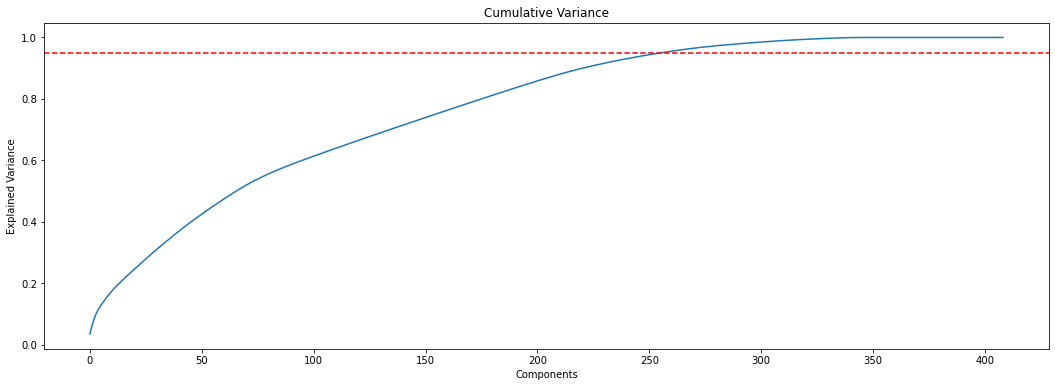

In [9]:
PCA = sk_decomp.PCA().fit(X)

plt.figure(figsize = (18, 6))

plt.plot(np.cumsum(PCA.explained_variance_ratio_))
plt.axhline(y=0.95, color="red", linestyle="--")

plt.ylabel("Explained Variance")
plt.xlabel("Components")
plt.title("Cumulative Variance")

plt.show()

We can see above that the first 250 components contribute to 95% of the explained variance in the feature set. This would imply we can cut the number of features in half but still retain 95% of the "useful" information.

However, when using this subset of features for modelling the test accuracy is slightly lower.

## Feature Importance

In [10]:
forest = sk_ens.RandomForestClassifier()

In [11]:
forest.fit(X, y)

RandomForestClassifier()

In [12]:
TOP_N = 20
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(forest.feature_importances_, index=list(X.columns))

Text(0, 0.5, 'Mean decrease in impurity')

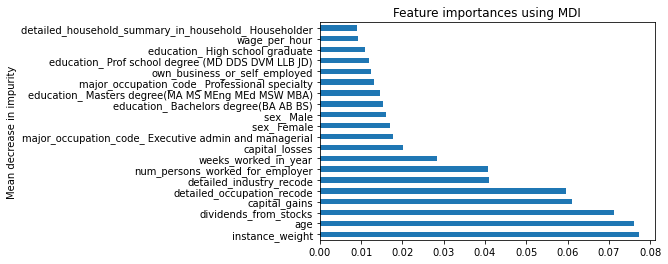

In [13]:
fig, ax = plt.subplots()
forest_importances.nlargest(TOP_N).plot.barh()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

We can see that instance weight (says ignore in metadata), age, dividends_from_stocks and capital_gains are the most important features when trying to predict your income status. 

In [14]:
result = permutation_importance(forest, X, y, n_repeats=3)
forest_importances = pd.Series(result.importances_mean, index=list(X.columns))

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()